In [ ]:
### HREF: https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa
### https://www.kaggle.com/aman193070021/cnn-vgg-animals10

### Importing Required Packages:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import requests
from PIL import Image
from io import BytesIO
import cv2
import pandas as pd
import numpy as np
import os

In [2]:
translate = {"cane": "Dog", "cavallo": "Horse", "elefante": "Elephant", "farfalla": "Butterfly", "gallina": "Chicken", "gatto": "Cat", "mucca": "Cow", "pecora": "Sheep", "scoiattolo": "Squirrel", "ragno": "Spider"}

### Loading Data:

In [ ]:
### Change the filepath accordingly. I used Kaggle GPU for faster processing

In [3]:
##### Creating Dataframe of images' path #####
# Class 2 has 1446 imges only. To maintain uniformty of counts among different classes, choose only first 1400 images.
foldernames = os.listdir('/kaggle/input/animals10/raw-img/')
files, files2, target, target2 = [], [], [], []

for i, folder in enumerate(foldernames):
    filenames = os.listdir("/kaggle/input/animals10/raw-img/" + folder);
    count = 0
    for file in filenames:
        if count < 1400:
            files.append("/kaggle/input/animals10/raw-img/" + folder + "/" + file)
            target.append(translate[folder])
        else:
            files2.append("/kaggle/input/animals10/raw-img/" + folder + "/" + file)
            target2.append(translate[folder])
        count += 1

df = pd.DataFrame({'Filepath':files, 'Target':target})
dft = pd.DataFrame({'Filepath':files2, 'Target':target2})
train, test = train_test_split(df, test_size=0.2857, random_state = 0)
#del files, files2, target, target2, df

### Train and Test Data:

In [4]:
datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center = True,
        )

datagen_test = ImageDataGenerator(rescale=1./255, samplewise_center = True)

train_flow = datagen.flow_from_dataframe(train, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)
test_flow = datagen_test.flow_from_dataframe(test, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)

Found 10000 non-validated image filenames belonging to 10 classes.
Found 4000 non-validated image filenames belonging to 10 classes.


### Training CNN Model:

In [5]:
model = applications.VGG16(weights='imagenet', include_top = False, input_shape=(224, 224, 3))
flat1 = tf.keras.layers.Flatten()(model.output)
dropout1 = Dropout(0.1)(flat1)
class1 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
dropout2 = Dropout(0.1)(class1)
output = tf.keras.layers.Dense(10, activation='softmax')(dropout2)
model = Model(inputs = model.inputs, outputs = output)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta=0.0001, min_lr = 1e-8)

model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=1e-3, momentum=0.9), metrics = ['accuracy'])
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [6]:
history = model.fit_generator(train_flow, epochs = 10, validation_data = test_flow, callbacks=[ModelCheckpoint('VGG16.model', monitor='val_acc'), reduce_lr])

Epoch 1/10
313/313 [==============================] - 326s 1s/step - loss: 0.9442 - accuracy: 0.6772 - val_loss: 0.5588 - val_accuracy: 0.8242 - lr: 0.0010
Epoch 2/10
313/313 [==============================] - 230s 736ms/step - loss: 0.4239 - accuracy: 0.8611 - val_loss: 0.3960 - val_accuracy: 0.8733 - lr: 0.0010
Epoch 3/10
313/313 [==============================] - 230s 735ms/step - loss: 0.3122 - accuracy: 0.8997 - val_loss: 0.3277 - val_accuracy: 0.8970 - lr: 0.0010
Epoch 4/10
313/313 [==============================] - 229s 731ms/step - loss: 0.2534 - accuracy: 0.9161 - val_loss: 0.2278 - val_accuracy: 0.9293 - lr: 0.0010
Epoch 5/10
313/313 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9334
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
313/313 [==============================] - 231s 737ms/step - loss: 0.2073 - accuracy: 0.9334 - val_loss: 0.2648 - val_accuracy: 0.9135 - lr: 0.0010
Epoch 6/10
313/313 [======================

In [ ]:
### Loss and Accuracy Plots

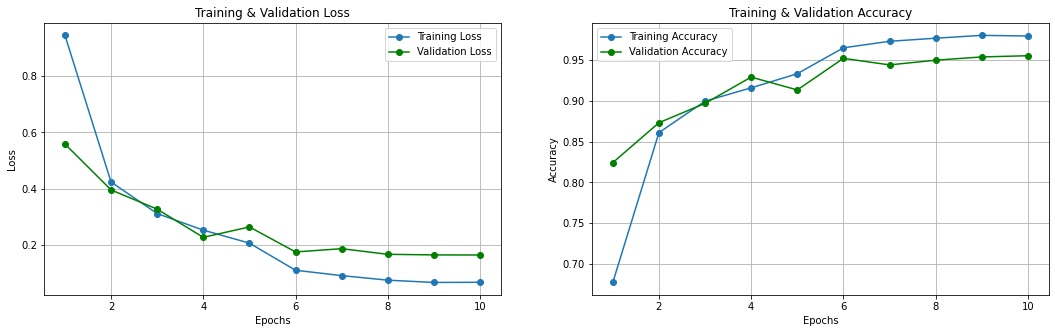

In [7]:
loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']
epochs = range(1, len(history.history['accuracy'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[1].plot(epochs, acc_vals, marker='o', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()
del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

In [8]:
test2_flow = datagen_test.flow_from_dataframe(dft, x_col = 'Filepath', y_col = 'Target', target_size=(224, 224), interpolation = 'lanczos', validate_filenames = False)
score = model.evaluate(test2_flow)

Found 12179 non-validated image filenames belonging to 10 classes.
381/381 [==============================] - 169s 444ms/step - loss: 0.1732 - accuracy: 0.9519


### Checking Predictions:

In [20]:
##### Append your urls of animals here for prediction #####
img_url = ['https://pbs.twimg.com/profile_images/378800000532546226/dbe5f0727b69487016ffd67a6689e75a.jpeg',
           'https://i.ytimg.com/vi/UwtTSqTbWzg/maxresdefault.jpg',
           'https://images.unsplash.com/photo-1547399300-7613d8f5f8f1?ixlib=rb-1.2.1&w=1000&q=80',
           'https://www.theartofdoingstuff.com/wp-content/uploads/2014/06/Studio_BlkCpMrnHn_8771_L2.jpg',
           'https://www.k9rl.com/wp-content/uploads/2017/01/Tibetan-Spaniel-dog.jpg',
           'https://static.boredpanda.com/blog/wp-content/uploads/2016/06/I-found-freedom-with-horses-576d2d0804976__880.jpg',
           'https://th.bing.com/th/id/OIP.tOb0fbG7VgjMf2Mj7Sa9igHaEK?pid=Api&rs=1',
           'https://pixfeeds.com/images/topic/2779/1200-2779-butterflies-photo1.jpg',
           'https://th.bing.com/th/id/OIP.GmYkDxsD--csxHFes-lWFwHaDS?pid=Api&rs=1'
          ]
img_get = []

!mkdir Downloaded_Images

from PIL import Image
import io
import requests
byteImgIO = io.BytesIO()

for i in range(len(img_url)):
    r = requests.get(img_url[i])
    byteImg = Image.open(io.BytesIO(r.content))
    byteImg.save('/kaggle/working/Downloaded_Images_new/image' + str(i) + '.png')
    
# Load Images to array
new_images = []
for i in range(len(img_url)):
    temp = np.array(tf.keras.preprocessing.image.load_img( '/kaggle/working/Downloaded_Images_new/image' + str(i) + '.png', color_mode = "rgb", target_size = (224, 224), interpolation="lanczos")) / 255.0
    new_images.append(temp)
new_images = np.array(new_images)

In [22]:
# Store predictions in out
predictions = model.predict(new_images)
pred_ints = predictions.argmax(axis = -1)
out = []
for x in pred_ints:
    labels = train_flow.class_indices
    for label, val in labels.items():
        if val == x:
            out.append(label)

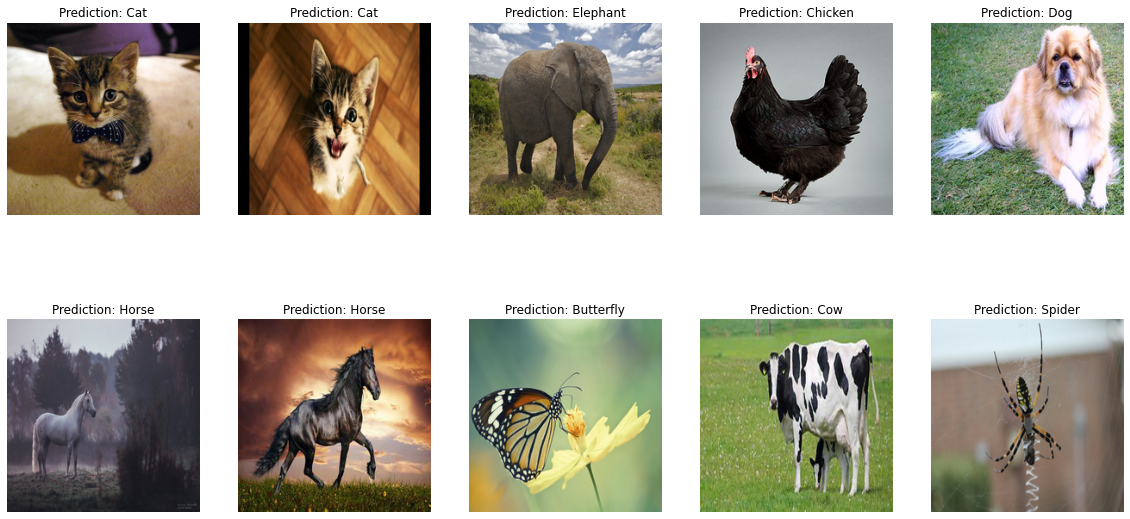

In [23]:
##### Print images and their predicitons #####

rows,cols = ((len(new_images) - 1) // 5 ) + 1,5
temp_axis = rows * 5
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,temp_axis))
for i in range(len(new_images)):
    temp = 'Prediction: ' + out[i]
    axes[i//cols, i%cols].set_title(temp)
    axes[i//cols, i%cols].axis('off')
    axes[i//cols, i%cols].imshow(new_images[i])
fig.savefig('New_Images_Prediction.eps', format='eps')